
# AI-Assignment - 3 : IBM-Project-32728-1660211830


## Problem Statement :- Build CNN Model for Classification Of Flowers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
ls

'Colab Notebooks'/   flowers/   Flowers-Dataset.zip   flowers.h5


In [ ]:
!unzip Flowers-Dataset.zip

Archive:  Flowers-Dataset.zip
replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/1055

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_dir ="../input/flowers-recognition/flowers/flowers"

Data 

In [ ]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [ ]:
database.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
flower_name_dict={'daisy':0 ,
                  'dandelion':1,
                  'rose':2 ,
                  'sunflower':3 ,
                  'tulip':4}

def encode_label(img_label):
    return flower_name_dict[img_label] 

In [ ]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

In [ ]:
def show_batch(dl,invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

def show_sample(image, label,invert=True):
    print("Label :" +database.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :daisy(0)


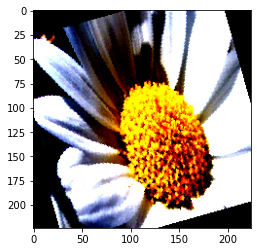

In [ ]:
show_sample(*database[1])

# Put them in Val_set and train_set

In [ ]:
validation_size = 500
training_size = len(database) - validation_size

In [ ]:
train_ds, val_ds_main = random_split(database,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[300, 200])
len(train_ds), len(val_ds)


(3823, 300)

In [ ]:
batch_size=32

In [ ]:
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds, batch_size)

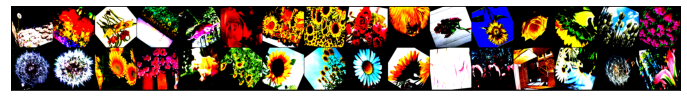

In [ ]:
show_batch(train_dl,invert=True)

# 1. Training the Image Classification using own build CNN

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = FlowerModel()
model

FlowerModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=5

In [ ]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]:', out[0])
  break

images.shape: torch.Size([32, 3, 224, 224])
out.shape: torch.Size([32, 5])
out[0]: tensor([ 0.0152,  0.0154,  0.0201, -0.0167,  0.0118], grad_fn=<SelectBackward>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Get GPU up on running

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
nvidia-smi

# Training and Validation Datasets
While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.


# Dataset Spliting Ratio :


Coverting the Dataset Ratio of :  70:10:20

Training - 70%

Testing - 20%

Validation - 10%

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);


In [ ]:
model = to_device(FlowerModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 1.608873724937439, 'val_acc': 0.21250000596046448}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
try1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.4695, val_loss: 1.3552, val_acc: 0.4062
Epoch [1], train_loss: 1.2814, val_loss: 1.2826, val_acc: 0.4135
Epoch [2], train_loss: 1.2296, val_loss: 1.0998, val_acc: 0.4896
Epoch [3], train_loss: 1.1651, val_loss: 1.0998, val_acc: 0.5052
Epoch [4], train_loss: 1.1264, val_loss: 1.0798, val_acc: 0.5688
Epoch [5], train_loss: 1.0512, val_loss: 0.9706, val_acc: 0.6167
Epoch [6], train_loss: 0.9572, val_loss: 0.9379, val_acc: 0.6552
Epoch [7], train_loss: 0.8859, val_loss: 0.8981, val_acc: 0.6458
Epoch [8], train_loss: 0.8644, val_loss: 0.9907, val_acc: 0.6042
Epoch [9], train_loss: 0.8425, val_loss: 0.8773, val_acc: 0.6677
CPU times: user 5min 28s, sys: 7.62 s, total: 5min 36s
Wall time: 5min 55s


In [ ]:
def plot_accuracies(try1):
    accuracies = [x['val_acc'] for x in try1]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

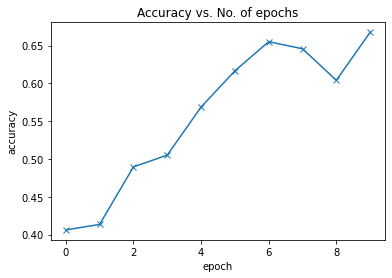

In [ ]:
plot_accuracies(try1)

In [ ]:
def plot_losses(try1):
    train_losses = [x.get('train_loss') for x in try1]
    val_losses = [x['val_loss'] for x in try1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

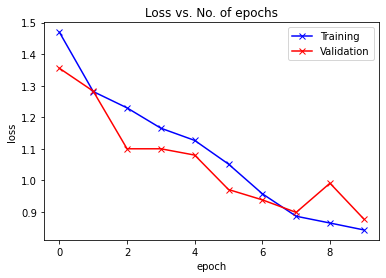

In [ ]:
plot_losses(try1)

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_loss': 0.8579890727996826, 'val_acc': 0.6741071343421936}

As you can see the val_acc is only 67% when using CNN that are bulid from scratch. Now let try pre-trained model see we can get better accurate.

# Predict the image 

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: daisy , Predicted: tulip


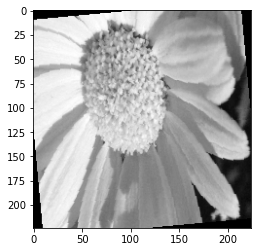

In [ ]:
img, label = test_ds[1]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

Label: daisy , Predicted: daisy


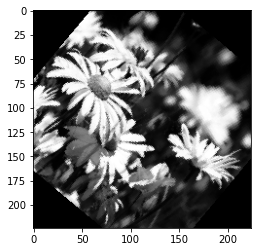

In [ ]:
img, label = test_ds[5]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

# Saving the model work

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='normalCNNtry2', 
                       epochs=num_epochs, 
                       lr=lr, 
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=try1[-1]['val_loss'], 
                   val_acc=try1[-1]['val_acc'],
                   train_loss=try1[-1]['train_loss'])

[jovian] Metrics logged.


In [ ]:
project_name='Flower-classification'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['Flower-classification.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/edsenmichaelcy/Flower-classification


<IPython.core.display.Javascript object>

# 2. Transfer Learning method using Restnet50 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModelResnet50(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModelResnet50(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


{'val_loss': 1.6078904867172241, 'val_acc': 0.19166666269302368}

In [ ]:
epochs = 10
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [ ]:
%%time
try2 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

Epoch [0], train_loss: 1.2455, val_loss: 1.3432, val_acc: 0.4938
Epoch [1], train_loss: 1.2389, val_loss: 1.2355, val_acc: 0.5885
Epoch [2], train_loss: 1.2198, val_loss: 1.2353, val_acc: 0.5729
Epoch [3], train_loss: 1.2085, val_loss: 1.1697, val_acc: 0.6448
Epoch [4], train_loss: 1.1836, val_loss: 1.2266, val_acc: 0.6333
Epoch [5], train_loss: 1.1881, val_loss: 1.2026, val_acc: 0.6323
Epoch [6], train_loss: 1.1731, val_loss: 1.1878, val_acc: 0.6448
Epoch [7], train_loss: 1.1653, val_loss: 1.2514, val_acc: 0.5969
Epoch [8], train_loss: 1.1697, val_loss: 1.1580, val_acc: 0.6760
Epoch [9], train_loss: 1.1621, val_loss: 1.1579, val_acc: 0.6521
CPU times: user 7min 33s, sys: 1min 11s, total: 8min 44s
Wall time: 8min 58s


In [ ]:
evaluate(model, test_dl)

{'val_loss': 1.1230988502502441, 'val_acc': 0.7366071343421936}

Our val_acc when using Retnet50 is 73%. It is not that good let try retnet 18 and see.

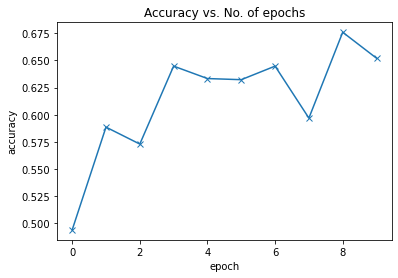

In [ ]:
def plot_accuracies(try2):
    accuracies = [x['val_acc'] for x in try2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try2)

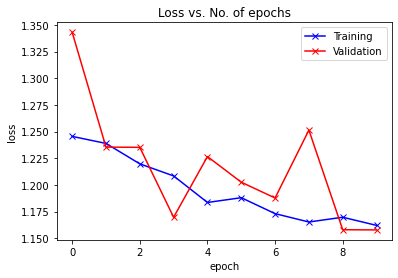

In [ ]:
def plot_losses(try2):
    train_losses = [x.get('train_loss') for x in try2]
    val_losses = [x['val_loss'] for x in try2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try2)

As you can see the **Validation** graph is increase in some point of training. This mean the model is overfitting and it is bad because it is specialize in this model but not as general.When we train our model we want to make sure the model is generalise as much as possible.

# Predict image

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: sunflower , Predicted: sunflower


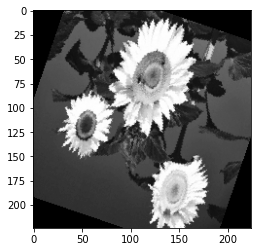

In [ ]:
img, label = test_ds[70]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

Label: daisy , Predicted: sunflower


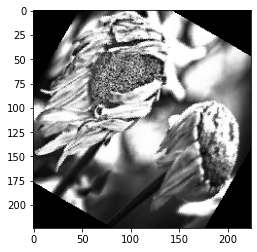

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

# 3. Transfer Learning using Restnet18 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel18(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModel18(), device)
evaluate(model, val_dl)

{'val_loss': 1.6147499084472656, 'val_acc': 0.22187499701976776}

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
try3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1022, val_loss: 1.1361, val_acc: 0.7563
Epoch [1], train_loss: 1.0922, val_loss: 1.1122, val_acc: 0.7583
Epoch [2], train_loss: 1.0755, val_loss: 1.1079, val_acc: 0.7552
Epoch [3], train_loss: 1.0720, val_loss: 1.1114, val_acc: 0.7719
Epoch [4], train_loss: 1.0595, val_loss: 1.0859, val_acc: 0.7875
CPU times: user 2min 47s, sys: 1.91 s, total: 2min 49s
Wall time: 2min 55s


In [ ]:
%%time
try3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.0671, val_loss: 1.1159, val_acc: 0.7656
Epoch [1], train_loss: 1.0603, val_loss: 1.0932, val_acc: 0.7979
Epoch [2], train_loss: 1.0536, val_loss: 1.0804, val_acc: 0.8000
Epoch [3], train_loss: 1.0532, val_loss: 1.0977, val_acc: 0.7833
Epoch [4], train_loss: 1.0378, val_loss: 1.0395, val_acc: 0.8510
CPU times: user 2min 48s, sys: 1.97 s, total: 2min 50s
Wall time: 2min 56s


In [ ]:
evaluate(model, test_dl)


{'val_loss': 1.0342780351638794, 'val_acc': 0.8571428656578064}

As you can see by using resnet 18  and tranfer learning the val_acc will be able to reach to 85%. It is more better then resnet50 and CNN(Bulid from scratch)

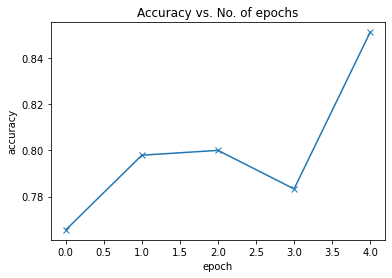

In [ ]:
def plot_accuracies(try3):
    accuracies = [x['val_acc'] for x in try3]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try3)

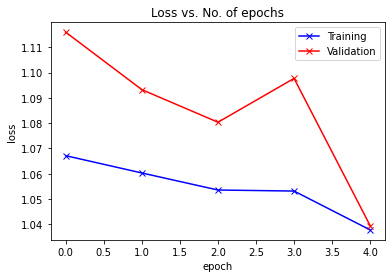

In [ ]:
def plot_losses(try3):
    train_losses = [x.get('train_loss') for x in try3]
    val_losses = [x['val_loss'] for x in try3]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try3)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: sunflower , Predicted: tulip


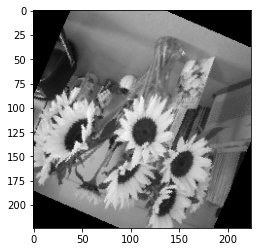

In [ ]:
img, label = test_ds[17]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))


Label: daisy , Predicted: daisy


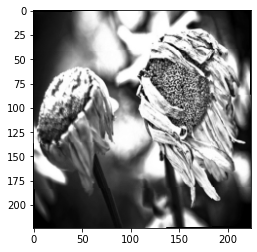

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))

